In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import random
random.seed = 1

# Define tickers and download data
tickers = ['AAPL', 'MSFT', 'GOOGL']
data = yf.download(tickers, start="2020-01-01", end="2025-01-01")

# Extract just the Close prices
close_prices = data.loc[:, 'Close']

# Drop any rows with missing values
close_prices = close_prices.dropna()

# Preprocess: convert to cumulative returns
def preprocess_prices(df):
    return df.pct_change().add(1).dropna().cumprod()

close_prices = preprocess_prices(close_prices)

def preprocess_returns(df):
    returns = df.pct_change().dropna()
    return returns

returns_ = preprocess_returns(close_prices)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


Will be used later.

# Environment Creation

In [4]:
import gym
from gym import spaces
import numpy as np
import pandas as pd

class PortfolioEnv(gym.Env):
    def __init__(self, prices, returns, window_size=100, initial_balance=1_000_000):
        super().__init__()
        self.prices = prices
        self.returns = returns
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.num_assets = prices.shape[1]
        self.action_space = spaces.Box(low=0, high=1, shape=(self.num_assets,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(window_size, self.num_assets), dtype=np.float32)

        self.reset()

    def reset(self):
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.weights = np.ones(self.num_assets) / self.num_assets
        self.history = []

        return self._get_observation()

    def _get_observation(self):
        return self.prices[self.current_step - self.window_size:self.current_step].values

    def step(self, action):
        action = np.clip(action, 0, 1)
    
        # Normalize with epsilon to avoid division by 0
        sum_action = np.sum(action)
        if sum_action < 1e-8:
            action = np.ones_like(action) / len(action)  # fallback to uniform
        else:
            action /= sum_action
    
        current_returns = self.returns.iloc[self.current_step].values
        portfolio_return = np.dot(action, current_returns + 1)
    
        # Safe reward: guard against log(0) or log(negative)
        reward = np.log(max(portfolio_return, 1e-8))
    
        self.balance *= portfolio_return
        self.weights = action
        self.history.append(self.balance)
    
        self.current_step += 1
        done = self.current_step >= len(self.returns) - 1
    
        return self._get_observation(), reward, done, {}


In [5]:
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv

def make_env_basis(prices_df, returns_df):
    def _init():
        return PortfolioEnv(prices=prices_df, returns=returns_df)
    return _init

# Build dummy vectorized env
env = DummyVecEnv([make_env_basis(close_prices, returns_)])

# Train the model
model_basis = A2C("MlpPolicy", env, verbose=1, learning_rate=1e-4)
model_basis.learn(total_timesteps=100_000)
model_basis.save("a2c_basis")

/opt/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 3778     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -4.25    |
|    explained_variance | 0.65     |
|    learning_rate      | 0.0001   |
|    n_updates          | 99       |
|    policy_loss        | 0.0828   |
|    std                | 0.999    |
|    value_loss         | 0.000682 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 3897     |
|    iterations         | 200      |
|    time_elapsed       | 0        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -4.26    |
|    explained_variance | 0.323    |
|    learning_rate      | 0.0001   |
|    n_updates          | 199      |
|    policy_loss     

# Testing on Ornstein - Uhlenbeck (OU) Process

The OU process generates mean-reverting behavior. If your model learns to exploit this (e.g., buy low and sell high), it’s a strong indicator that it's learning structure, not noise.

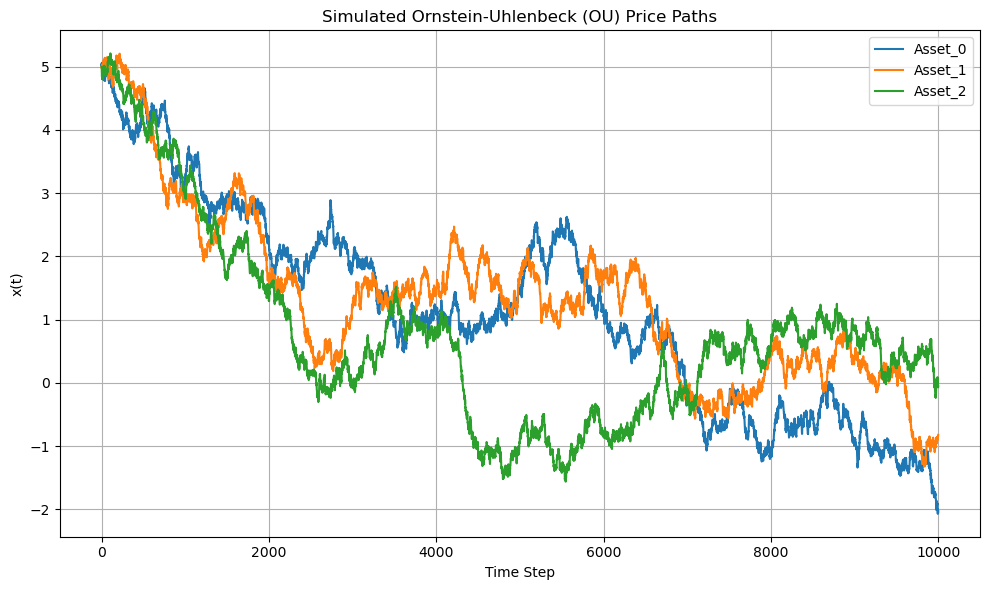

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_ou_process(n_assets=3, n_steps=10000, theta=0.15, mu=0.0, sigma=0.5, dt=1/252, x0=5.0, seed=1):
    np.random.seed(seed)
    prices = np.zeros((n_steps, n_assets))
    prices[0] = x0  # Start far from the mean
    for t in range(1, n_steps):
        noise = np.random.normal(size=n_assets)
        prices[t] = prices[t - 1] + theta * (mu - prices[t - 1]) * dt + sigma * np.sqrt(dt) * noise
    return pd.DataFrame(prices, columns=[f'Asset_{i}' for i in range(n_assets)])

# Generate OU process data
ou_prices = generate_ou_process(mu=0.0, x0=5.0)

# Plot x(t) for each asset
plt.figure(figsize=(10, 6))
for column in ou_prices.columns:
    plt.plot(ou_prices.index, ou_prices[column], label=column)

plt.title("Simulated Ornstein-Uhlenbeck (OU) Price Paths")
plt.xlabel("Time Step")
plt.ylabel("x(t)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
import gym
from gym import spaces
import numpy as np

class OUControlEnv(gym.Env):
    def __init__(self, theta=0.15, mu=0.0, sigma=0.1, dt=1/252, max_steps=10000):
        super().__init__()
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.max_steps = max_steps

        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32)

    def reset(self):
        self.x = 5.0  # start far from mean
        self.steps = 0
        return np.array([self.x], dtype=np.float32)

    def step(self, action):
        action = float(np.clip(action, -1.0, 1.0))
        noise = np.random.normal()
        dx = self.theta * (self.mu - self.x) * self.dt + self.sigma * np.sqrt(self.dt) * noise + action
        self.x += dx
        self.steps += 1

        reward = -(self.x - self.mu)**2  # penalize distance from μ, not from 0
        done = self.steps >= self.max_steps
        return np.array([self.x], dtype=np.float32), reward, done, {}


from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv

env = DummyVecEnv([lambda: OUControlEnv()])
model = A2C("MlpPolicy", env, verbose=0, learning_rate=1e-4)
model.learn(total_timesteps=100)

/opt/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/var/folders/q3/j_2_rkx148lffppwjbq3_rt80000gq/T/ipykernel_44291/3795561189.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action = float(np.clip(action, -1.0, 1.0))


/var/folders/q3/j_2_rkx148lffppwjbq3_rt80000gq/T/ipykernel_44291/3795561189.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action = float(np.clip(action, -1.0, 1.0))


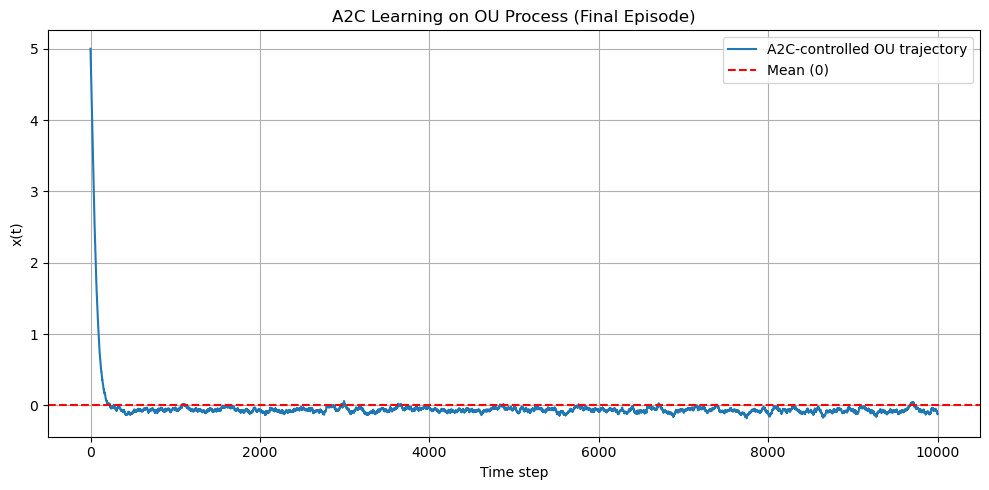

In [9]:
env_eval = OUControlEnv()
obs = env_eval.reset()
trajectory = [obs[0]]

for _ in range(env_eval.max_steps):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _ = env_eval.step(action)
    trajectory.append(obs[0])
    if done:
        break

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(trajectory, label="A2C-controlled OU trajectory")
plt.axhline(0, linestyle="--", color="red", label="Mean (0)")
plt.title("A2C Learning on OU Process (Final Episode)")
plt.xlabel("Time step")
plt.ylabel("x(t)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Testing on S&P500

In [11]:
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv

# Create environment using current variables
def make_env():
    def _init():
        return PortfolioEnv(prices=close_prices, returns=returns_)
    return _init

env = DummyVecEnv([make_env()])

# Load trained model
model_basis = A2C.load("a2c_basis")

# Run test episode
obs = env.reset()
done = False
portfolio_value = [env.envs[0].balance]
actions = []

while not done:
    action, _ = model_basis.predict(obs)
    obs, reward, done, _ = env.step(action)
    actions.append(action)
    
    # Avoid recording balance after reset
    if not done:
        portfolio_value.append(env.envs[0].balance)

equal_weight = np.ones(close_prices.shape[1]) / close_prices.shape[1]
ew_portfolio = [1_000_000]

for i in range(len(returns_)):
    daily_return = returns_.iloc[i].values + 1
    ew_portfolio.append(ew_portfolio[-1] * np.dot(equal_weight, daily_return))

/opt/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


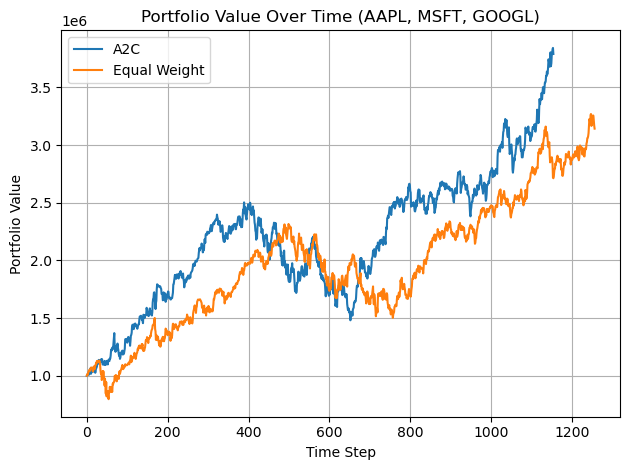

A2C Final Value: 3,789,708.9290
Equal Weight Final Value: 3,142,314.3242
A2C Sharpe Ratio: 1.0622
Equal Weight Sharpe Ratio: 0.8081


In [12]:
import matplotlib.pyplot as plt

plt.plot(portfolio_value, label="A2C")
plt.plot(ew_portfolio, label="Equal Weight")
plt.title("Portfolio Value Over Time (AAPL, MSFT, GOOGL)")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

def sharpe_ratio(values):
    returns = np.diff(np.log(values))
    return np.mean(returns) / (np.std(returns) + 1e-8) * np.sqrt(252)


print(f"A2C Final Value: {portfolio_value[-1]:,.4f}")
print(f"Equal Weight Final Value: {ew_portfolio[-1]:,.4f}")
print(f"A2C Sharpe Ratio: {sharpe_ratio(portfolio_value):.4f}")
print(f"Equal Weight Sharpe Ratio: {sharpe_ratio(ew_portfolio):.4f}")

# Adding Transaction Costs

We incorporate a proportional transaction cost based on the change in portfolio weights. TCR = transaction cost rate.

$$Cost_t = TCR * sum(|w_t - w_{t-1}|)$$

Where:
- `w_t` = new action (weights)
- `w_{t-1}` = previous portfolio weights
- `TCR` = 0.001 (0.1%) by default

Changes compared to other PortfolioEnv class is mostly in the init and step functions.

In [22]:
import gym
from gym import spaces
import numpy as np
import pandas as pd

class PortfolioEnvTrans(gym.Env):
    def __init__(self, prices, returns, window_size=100, initial_balance=1_000_000, transaction_cost=0.001):
        super().__init__()
        self.prices = prices
        self.returns = returns
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.transaction_cost = transaction_cost
        self.num_assets = prices.shape[1]
        self.action_space = spaces.Box(low=0, high=1, shape=(self.num_assets,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(window_size, self.num_assets), dtype=np.float32)
        self.reset()

    def step(self, action):
        action = np.clip(action, 0, 1)
        sum_action = np.sum(action)
        if sum_action < 1e-8:
            action = np.ones_like(action) / len(action)
        else:
            action /= sum_action
    
        current_returns = self.returns.iloc[self.current_step].values
    
        # Expected gain vs staying put
        expected_gain = np.dot(action, current_returns + 1)
        default_gain = np.dot(self.weights, current_returns + 1)
    
        # OPTIONAL: Add trade threshold inertia
        if expected_gain < default_gain * (1 + self.transaction_cost):
            action = self.weights  # Don't trade if it's not clearly better
    
        # Transaction cost
        turnover = np.sum(np.abs(action - self.weights))
        cost = self.transaction_cost * turnover
    
        # Net return and reward shaping
        portfolio_return = np.dot(action, current_returns + 1)
        net_return = portfolio_return * (1 - cost)
    
        # Strong penalty for trading, encouraging long-term thinking
        reward = np.log(max(net_return, 1e-8)) - 50 * self.transaction_cost * turnover
    
        self.balance *= net_return
        self.weights = action
        self.history.append(self.balance)
        self.turnover_log.append(turnover)  # for later plotting
    
        self.current_step += 1
        done = self.current_step >= len(self.returns) - 1
    
        return self._get_observation(), reward, done, {}

    def _get_observation(self):
        return self.prices[self.current_step - self.window_size:self.current_step].values

    def reset(self):
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.weights = np.ones(self.num_assets) / self.num_assets
        self.history = []
        self.turnover_log = []  # track turnover for analysis
        return self._get_observation()

In [24]:
def make_env_transaction(prices_df, returns_df):
    def _init():
        return PortfolioEnvTrans(prices=prices_df, returns=returns_df, transaction_cost=0.001)
    return _init

# Build dummy vectorized env
env = DummyVecEnv([make_env_transaction(close_prices, returns_)])

# Train the model
model_transaction = A2C("MlpPolicy", env, verbose=1, learning_rate=1e-6)
model_transaction.learn(total_timesteps=100_000)
model_transaction.save("a2c_transaction")

/opt/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 2875     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -4.26    |
|    explained_variance | -6.22    |
|    learning_rate      | 1e-06    |
|    n_updates          | 99       |
|    policy_loss        | -0.14    |
|    std                | 1        |
|    value_loss         | 0.00273  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 3134     |
|    iterations         | 200      |
|    time_elapsed       | 0        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -4.26    |
|    explained_variance | -0.314   |
|    learning_rate      | 1e-06    |
|    n_updates          | 199      |
|    policy_loss     

# 

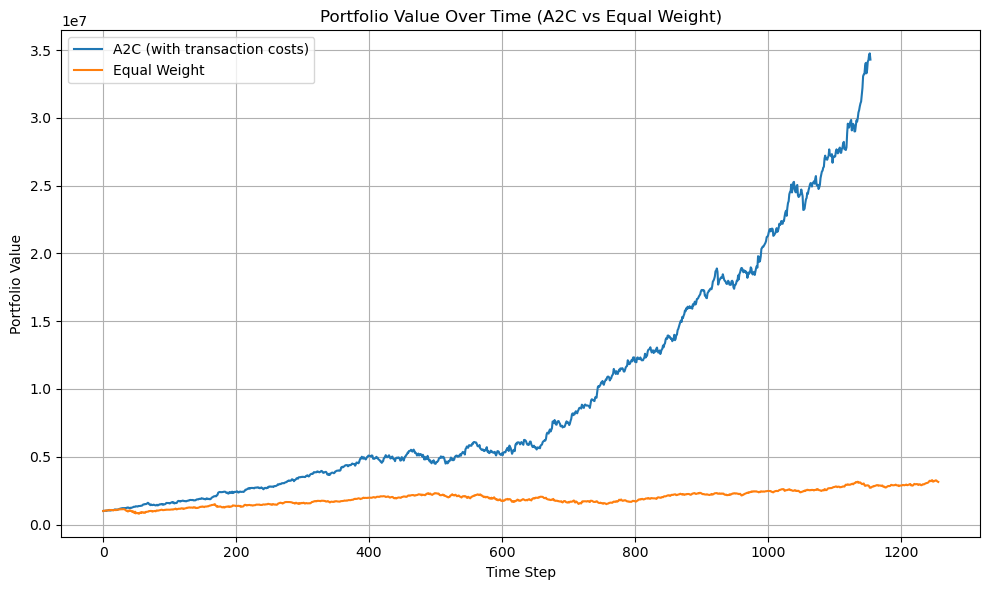

In [25]:
# Load trained model
model_transaction = A2C.load("a2c_transaction")

# Run test
obs = env.reset()
done = False
portfolio_value = [env.envs[0].balance]
while not done:
    action, _ = model_transaction.predict(obs)
    obs, reward, done, _ = env.step(action)
    if not done:
        portfolio_value.append(env.envs[0].balance)

# Equal weight benchmark
equal_weight = np.ones(close_prices.shape[1]) / close_prices.shape[1]
ew_portfolio = [1_000_000]
for i in range(len(returns_)):
    daily_return = returns_.iloc[i].values + 1
    ew_portfolio.append(ew_portfolio[-1] * np.dot(equal_weight, daily_return))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(portfolio_value, label="A2C (with transaction costs)")
plt.plot(ew_portfolio, label="Equal Weight")
plt.title("Portfolio Value Over Time (A2C vs Equal Weight)")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Turnover = how much you need to trade to go from one allocation to the next. This assumes trading is proportional to weight difference, and ignores actual prices/volumes — which is fine for reinforcement learning environments. High turnover = bad in high-cost environments, unless justified by returns.

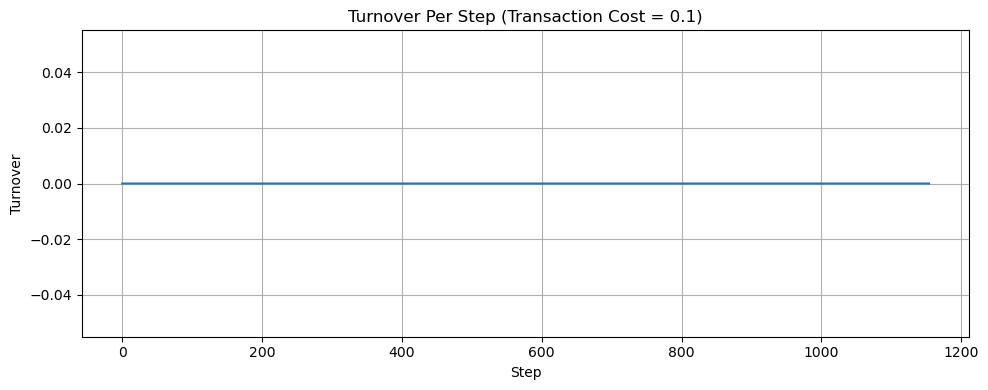

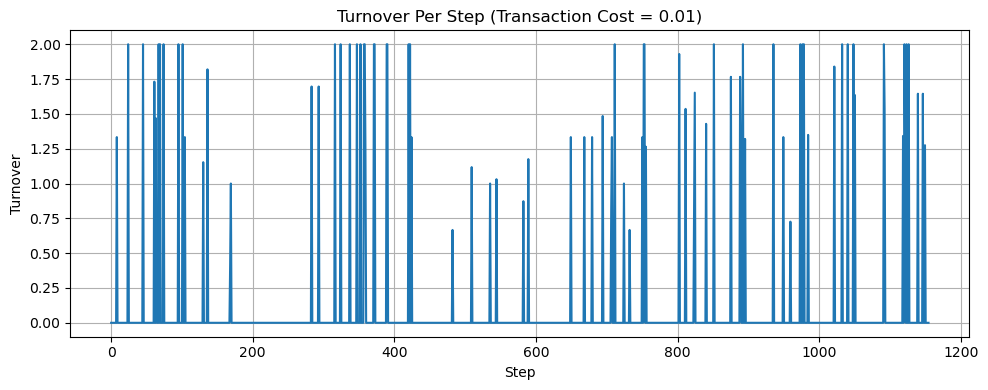

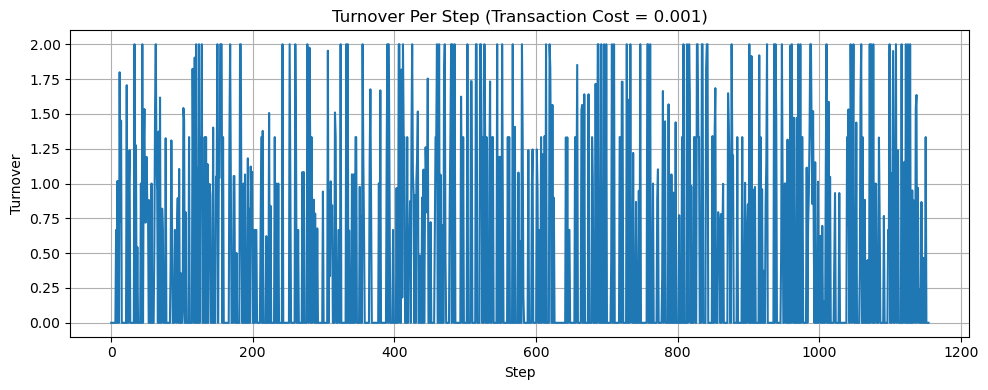

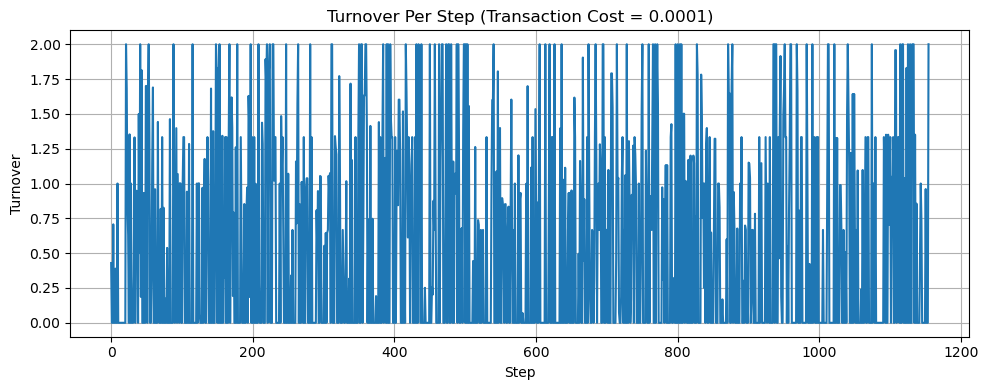

In [27]:
# Define transaction costs to test
transaction_costs = [0.1, 0.01, 0.001, 0.0001]
turnover_results = {}

# Run the A2C model on each transaction cost and collect turnover logs
for cost in transaction_costs:
    test_env = PortfolioEnvTrans(prices=close_prices, returns=returns_, transaction_cost=cost)
    obs = test_env.reset()
    portfolio_value = [test_env.balance]
    done = False

    while not done:
        action, _ = model_transaction.predict(obs.reshape(1, *obs.shape))
        obs, reward, done, _ = test_env.step(action[0])
        if not done:
            portfolio_value.append(test_env.balance)

    turnover_results[cost] = test_env.turnover_log.copy()

# Plot each turnover series in its own figure
for cost in transaction_costs:
    plt.figure(figsize=(10, 4))
    plt.plot(turnover_results[cost])
    plt.title(f"Turnover Per Step (Transaction Cost = {cost})")
    plt.xlabel("Step")
    plt.ylabel("Turnover")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

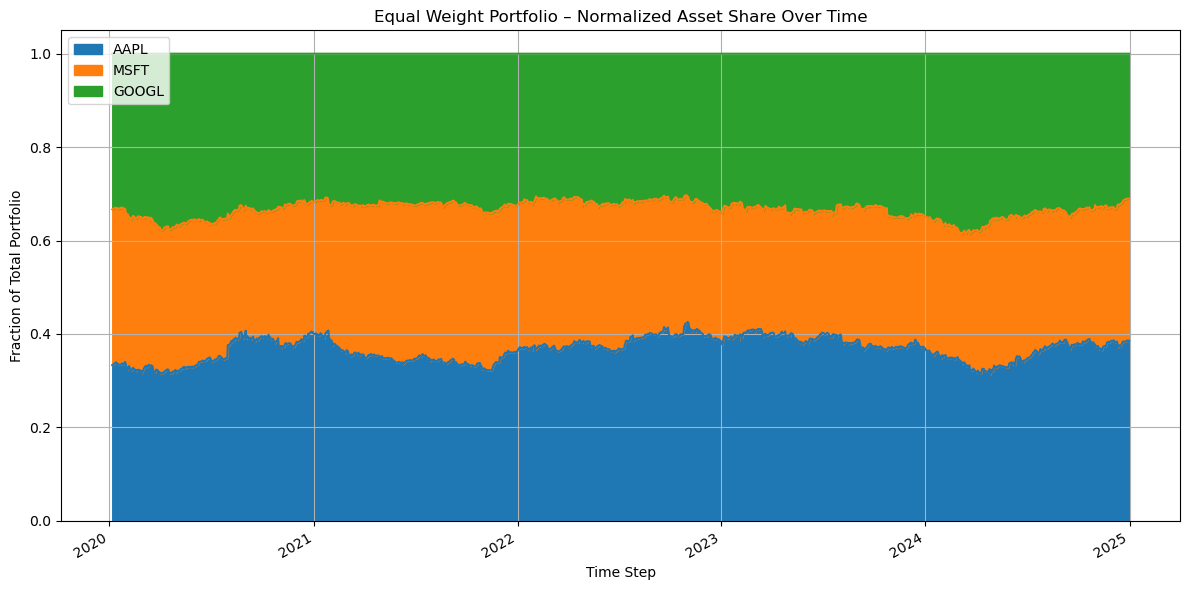

In [28]:
initial_capital = 1_000_000
equal_weight = np.ones(len(tickers)) / len(tickers)

# Initialize portfolio values
portfolio_values = pd.DataFrame(index=returns_.index, columns=tickers)
portfolio_values.iloc[0] = initial_capital * equal_weight

# Simulate equal-weight portfolio asset values
for t in range(1, len(returns_)):
    returns_step = returns_.iloc[t].values + 1
    portfolio_values.iloc[t] = portfolio_values.iloc[t - 1] * returns_step

portfolio_values.div(portfolio_values.sum(axis=1), axis=0).plot.area(figsize=(12, 6))
plt.title("Equal Weight Portfolio – Normalized Asset Share Over Time")
plt.xlabel("Time Step")
plt.ylabel("Fraction of Total Portfolio")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
